### Transfer Learning Task
- 쌀 이파리 병에 대한 분류

In [103]:
from glob import glob
import os

root = './datasets/rice_leaf_diseases_dataset/original/'

directories = glob(os.path.join(root,'*'))
dir_names = []

# root 경로 안 directory들의 이름 출력
for directory in directories:
    dir_names.append(directory[directory.rindex('\\') + 1:])

print(dir_names)

['Bacterialblight', 'Brownspot', 'Leafsmut']


In [44]:
# 각 폴더 안 이미지 파일의 이름을 '폴더명+숫자(01, 02, ...).png'로 변경
for name in dir_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        # 기존 파일명
        old_file = os.path.join(root + name + '/', file_name)

        # 변경 후 파일명
        new_file = os.path.join(root + name + '/', name + str(i + 1) + '.png')

        os.rename(old_file, new_file)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './datasets/rice_leaf_diseases_dataset/original/Bacterialblight/Bacterialblight10.png' -> './datasets/rice_leaf_diseases_dataset/original/Bacterialblight/Bacterialblight2.png'

In [104]:
IMAGE_SIZE = 64
BATCH_SIZE = 20

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 선언 - RGB 값을 0 ~ 1사이로 스케일링만
image_data_generator = ImageDataGenerator(rescale=1./255)

generator = image_data_generator.flow_from_directory(root,
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical')

print(generator.class_indices)

Found 4684 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


In [106]:
import pandas as pd

# 경로 및 target 클래스로 데이터프레임 생성
a_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
a_df

,file_paths,targets
0,./datasets/rice_leaf_diseases_dataset/original...,0
1,./datasets/rice_leaf_diseases_dataset/original...,0
2,./datasets/rice_leaf_diseases_dataset/original...,0
3,./datasets/rice_leaf_diseases_dataset/original...,0
4,./datasets/rice_leaf_diseases_dataset/original...,0
...,...,...
4679,./datasets/rice_leaf_diseases_dataset/original...,2
4680,./datasets/rice_leaf_diseases_dataset/original...,2
4681,./datasets/rice_leaf_diseases_dataset/original...,2
4682,./datasets/rice_leaf_diseases_dataset/original...,2


In [107]:
# file_path의 '\\'를 '/'로 변경
a_df.loc[:, 'file_paths'] = a_df.file_paths.apply(lambda x: x.replace('\\', '/'))
a_df

,file_paths,targets
0,./datasets/rice_leaf_diseases_dataset/original...,0
1,./datasets/rice_leaf_diseases_dataset/original...,0
2,./datasets/rice_leaf_diseases_dataset/original...,0
3,./datasets/rice_leaf_diseases_dataset/original...,0
4,./datasets/rice_leaf_diseases_dataset/original...,0
...,...,...
4679,./datasets/rice_leaf_diseases_dataset/original...,2
4680,./datasets/rice_leaf_diseases_dataset/original...,2
4681,./datasets/rice_leaf_diseases_dataset/original...,2
4682,./datasets/rice_leaf_diseases_dataset/original...,2


In [108]:
from sklearn.model_selection import train_test_split

# train, test 데이터 세트 분할
X_train, X_test, y_train, y_test = \
            train_test_split(a_df.file_paths, a_df.targets, stratify=a_df.targets, test_size=0.2, random_state=124)

# train, test의 target 분포 출력
print(y_train.value_counts())
print(y_test.value_counts())

targets
1    1296
0    1283
2    1168
Name: count, dtype: int64
targets
1    324
0    321
2    292
Name: count, dtype: int64


In [109]:
from sklearn.model_selection import train_test_split

# validation 데이터 세트 분할
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

# train, validation의 target 분포 출력
print(y_train.value_counts())
print(y_val.value_counts())

targets
1    1037
0    1026
2     934
Name: count, dtype: int64
targets
1    259
0    257
2    234
Name: count, dtype: int64


In [110]:
import shutil

root = './datasets/rice_leaf_diseases_dataset/'

# train 이미지를 'train' 폴더에 복사
for file_path in X_train:
    almond_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + almond_dir)

    # train 폴더가 없으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [111]:
# validation과 test도 똑같이 생성
for file_path in X_val:
    almond_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + almond_dir)

    # train 폴더가 없으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [112]:
for file_path in X_test:
    almond_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + almond_dir)

    # train 폴더가 없으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [126]:
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# 이미지 Augmentation 함수
# Compose의 확률을 1로 지정하지 않는 이유는 원본 데이터도 fit하기 위함
def aug_transform(image):
    aug = A.Compose([
        A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.5, 1.5), rotate_limit=90, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        A.RandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE, scale=(0.1, 0.5), p=1),
        A.OneOf([
            A.ColorJitter(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
        ], p=1)
    ], p=0.8)

    return aug(image=image)['image']

# 위 함수를 ImageDataGenerator를 불러올 때 같이 실행
idg = ImageDataGenerator(preprocessing_function=aug_transform, rescale=1./255)

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './datasets/rice_leaf_diseases_dataset/train/'
val_dir = './datasets/rice_leaf_diseases_dataset/validation/'
test_dir = './datasets/rice_leaf_diseases_dataset/test/'

# train 데이터에는 Augmentation 적용
train_generator = idg.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# validation과 test 데이터는 RGB 값 스케일링만 실행
non_aug_idg = ImageDataGenerator(rescale=1./255)

val_generator = non_aug_idg.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = non_aug_idg.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# 각각의 클래스 분류 출력
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

Found 2997 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


### 모델 생성

In [128]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Classifier
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model.input, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

# 모델 생성 후 컴파일링
model = create_model(verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 50)                  │          25,6

 Total params: 14,740,491 (56.23 MB)

 Trainable params: 14,740,491 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
import gc

# Garbage Collector: 불필요한 object를 메모리에서 해제시킨다
# 쾌적하게 fit 가능 
gc.collect()

2653

In [131]:
# validation_split: train 데이터 중 일정 비율을 validation 데이터로 자동 분리해준다
# validation 데이터 따로 분리할 필요 없음
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=10, 
                    validation_data=(val_generator), 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 682ms/step - acc: 0.3235 - loss: 1.9821 - val_acc: 0.5827 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 768ms/step - acc: 0.3365 - loss: 1.1037 - val_acc: 0.3427 - val_loss: 1.0996 - learning_rate: 0.0010
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 847ms/step - acc: 0.3518 - loss: 1.1009 - val_acc: 0.3453 - val_loss: 1.1036 - learning_rate: 0.0010
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 887ms/step - acc: 0.3455 - loss: 1.1010 - val_acc: 0.5720 - val_loss: 1.0782 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 861ms/step - acc: 0.3584 - loss: 1.0888 - val_acc: 0.5947 - val_loss: 1.0301 - learning_rate: 1.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 843ms/step - acc: 0.3673 - loss: 1.0751 - val_acc: 0.5800 - val_loss: 0.8453 - learning_rate: 1.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 864ms/step - acc: 0.4000 - loss: 1.0396 - val_acc: 0.7613 - val_loss: 0.7229 -

In [133]:
model.evaluate(test_generator)

 1/47 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - acc: 0.8500 - loss: 0.6960

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - acc: 0.7356 - loss: 0.6736


[0.6696152091026306, 0.7171825170516968]

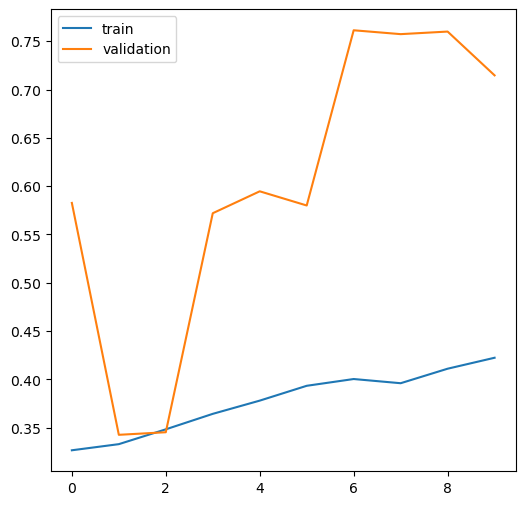

In [134]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)